In [1]:
%load_ext cudf.pandas

<img src="https://docs.xarray.dev/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Computing with Multiple Objects

Learning goals:

- Perform operations across multiple datasets
- Understand two important concepts: broadcasting and alignment.

In [2]:
%%cudf.pandas.profile

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%config InlineBackend.figure_format='retina'

plt.style.use("bmh")

np.random.seed(0)

                                                                                              
                                  Total time elapsed: 1.820 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Here is a motivating calculation where we subtract two DataArrays with data available at different locations in the (space, time) plane.

In [3]:
%%cudf.pandas.profile

arr1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("space", "time"),
    coords={"space": ["a", "b", "c"], "time": [0, 1, 2, 3]},
)
arr1

<xarray.DataArray (space: 3, time: 4)>
array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

                                                                                                              
                                          Total time elapsed: 1.859 seconds                                   
                                       208 GPU function calls in 1.664 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                    │ 2          │ 1.585       │ 0.792       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__len__      │ 92         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 92         │ 0.027       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__   │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__  │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__   │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__      │ 1          │ 0.006       │ 0.006       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [4]:
%%cudf.pandas.profile

arr2 = xr.DataArray(
    [0, 1],
    dims="space",
    coords={"space": ["b", "d"]},
)
arr2

<xarray.DataArray (space: 2)>
array([0, 1])
Coordinates:
  * space    (space) <U1 'b' 'd'

                                                                                                              
                                          Total time elapsed: 0.163 seconds                                   
                                       104 GPU function calls in 0.041 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                    │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__len__      │ 92         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__  │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Note that `arr1` is 2D; while `arr2` is 1D along `space` and has values at two locations only.

Now subtract the two.

In [5]:
%%cudf.pandas.profile

arr1 - arr2

<xarray.DataArray (space: 1, time: 4)>
array([[4, 5, 6, 7]])
Coordinates:
  * space    (space) <U1 'b'
  * time     (time) int64 0 1 2 3

                                                                                                              
                                          Total time elapsed: 0.542 seconds                                   
                                       138 GPU function calls in 0.335 seconds                                
                                        2 CPU function calls in 0.013 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__      │ 39         │ 0.012       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 79         │ 0.024       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals       │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.intersection │ 1          │ 0.010       │ 0.010       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index.get_indexer        │ 0          │ 0.000       │ 0.000       │ 2          │ 0.013       │ 0.007       │
│ ndarray.reshape          │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__lt__           │ 2          │ 0.104       │ 0.052       │ 0          │ 0.000       │ 0.000       │
│ ndarray.any              │ 2          │ 0.169       │ 0.085       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype           │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__   │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__      │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Index.get_indexer

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=72436;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

To understand this output, we must understand two fundamental concepts underlying computation with Xarray objects

1. Broadcasting: The objects need to have compatible shapes.
2. Alignment: The objects need to have values at the same coordinate labels



## Broadcasting: adjusting arrays to the same shape

**Broadcasting** allows an operator or a function to act on two or more arrays
to operate even if these arrays do not have the same shape. That said, not all
the dimensions can be subjected to broadcasting; they must meet certain rules.
The image below illustrates how an operation on arrays with
different coordinates will result in automatic broadcasting

![](../images/broadcasting_schematic.png)

Credit: Stephan Hoyer --
[xarray ECMWF Python workshop](https://docs.google.com/presentation/d/16CMY3g_OYr6fQplUZIDqVtG-SKZqsG8Ckwoj2oOqepU/)

Numpy's broadcasting rules, based on array shape, can sometimes be
difficult to understand and remember. Xarray does broadcasting by dimension name,
rather than array shape. This is a huge convenience.

Here are two 1D arrays

In [6]:
%%cudf.pandas.profile

array1 = xr.DataArray(
    np.arange(3),
    dims="space",
    coords={"space": ["a", "b", "c"]},
    name="array1",
)
array2 = xr.DataArray(
    np.arange(4),
    dims="time",
    coords={"time": [0, 1, 2, 3]},
    name="array2",
)
display(array1)
display(array2)

<xarray.DataArray 'array1' (space: 3)>
array([0, 1, 2])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'

<xarray.DataArray 'array2' (time: 4)>
array([0, 1, 2, 3])
Coordinates:
  * time     (time) int64 0 1 2 3

                                                                                                              
                                          Total time elapsed: 0.296 seconds                                   
                                       214 GPU function calls in 0.087 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                    │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__len__      │ 95         │ 0.030       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 95         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__   │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__  │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__   │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__      │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Let's subtract the two:

In [7]:
%%cudf.pandas.profile

array1 - array2

<xarray.DataArray (space: 3, time: 4)>
array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

                                                                                                             
                                          Total time elapsed: 0.245 seconds                                  
                                       178 GPU function calls in 0.071 seconds                               
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__     │ 81         │ 0.025       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 81         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__ │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

We see that the result is a 2D array. 

When subtracting, Xarray first realizes that `array1` is missing the dimension `time` and `array2` is missing the dimension `space`.  Xarray then broadcasts or "expands" both arrays to 2D with dimensions `space`, `time`. Here is an illustration:

![](../images/broadcasting_schematic.png)

While this detail is hidden, we can explicitly broadcast any number of arrays against each other using [xr.broadcast](https://docs.xarray.dev/en/stable/generated/xarray.broadcast.html)

In [8]:
%%cudf.pandas.profile

array1_broadcasted, array2_broadcasted = xr.broadcast(array1, array2)
display(array1_broadcasted.dims)
display(array2_broadcasted.dims)

('space', 'time')

('space', 'time')

                                                                                                              
                                          Total time elapsed: 0.188 seconds                                   
                                       144 GPU function calls in 0.054 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__      │ 65         │ 0.020       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 65         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__   │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

To get the final anomaly, Xarray calculates

In [9]:
%%cudf.pandas.profile

# identical to array1 - array2
array1_broadcasted - array2_broadcasted

<xarray.DataArray (space: 3, time: 4)>
array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

                                                                                                             
                                          Total time elapsed: 0.286 seconds                                  
                                       208 GPU function calls in 0.088 seconds                               
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__     │ 93         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 93         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals      │ 2          │ 0.004       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.equals       │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy        │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__ │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

### Broadcasting in numpy

For contrast let us examine the pure numpy version  of this calculation. We use [.data](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.data.html) to extract the underlying numpy array object.


In [10]:
%%cudf.pandas.profile

array1.data - array2.data

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

                                                                                              
                                  Total time elapsed: 3.758 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

To get this calculation to work, we need to insert new axes manually using [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis).

In [11]:
%%cudf.pandas.profile

array1.data[:, np.newaxis] - array2.data[np.newaxis, :]

array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1]])

                                                                                              
                                  Total time elapsed: 0.040 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘


Because xarray knows about dimension names we avoid having to create unnecessary
size-1 dimensions using `np.newaxis` or `.reshape`. This is yet another example where the _metadata_ (dimension names) reduces the mental overhead associated with coding a calculation

For more, see the [Xarray documentation](https://docs.xarray.dev/en/stable/user-guide/computation.html#broadcasting-by-dimension-name) and the [numpy documentation](https://numpy.org/doc/stable/user/basics.broadcasting.html) on broadcasting.


````{exercise}
:label: ex1

Consider the following 2D array. What are the dimensions of `array - array.mean("time")`?
```python
array = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("space", "time"),
    coords={"space": ["a", "b", "c"], "time": [0, 1, 2, 3]},
    name="array",
)
```
````

````{solution} ex1
:class: dropdown

```python
(array - array.mean("time")).dims
```
````

## Alignment: putting data on the same grid


When combining two input arrays using an arithmetic operation, both arrays must first be converted to the same coordinate system. This is "alignment".

![](../images/alignment_schematic.png)


Here are two 2D DataArrays with different shapes.

In [12]:
%%cudf.pandas.profile

arr1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("space", "time"),
    coords={"space": ["a", "b", "c"], "time": [0, 1, 2, 3]},
)
arr1

<xarray.DataArray (space: 3, time: 4)>
array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

                                                                                                              
                                          Total time elapsed: 0.307 seconds                                   
                                       208 GPU function calls in 0.092 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                    │ 2          │ 0.003       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__len__      │ 92         │ 0.032       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 92         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__  │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__   │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__  │ 6          │ 0.009       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__   │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__      │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [13]:
%%cudf.pandas.profile

arr2 = xr.DataArray(
    np.arange(14).reshape(2, 7),
    dims=("space", "time"),
    coords={"space": ["b", "d"], "time": [-2, -1, 0, 1, 2, 3, 4]},
)
arr2

<xarray.DataArray (space: 2, time: 7)>
array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13]])
Coordinates:
  * space    (space) <U1 'b' 'd'
  * time     (time) int64 -2 -1 0 1 2 3 4

                                                                                                              
                                          Total time elapsed: 0.289 seconds                                   
                                       205 GPU function calls in 0.087 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                    │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__len__      │ 89         │ 0.030       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 92         │ 0.029       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__  │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__   │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__  │ 6          │ 0.009       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__   │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__      │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

`arr1` and `arr2` have the same dimensions (space, time) but have values at different locations in the (space, time) plane  with some locations in common.

:::{note}
xarray assumes coordinate labels are in the same coordinate system such that space='b' in arr1 is the same as space='b' in arr2. For more sophisticated handling of coordinate systems see [rioxarray](https://corteva.github.io/rioxarray/stable/)
:::

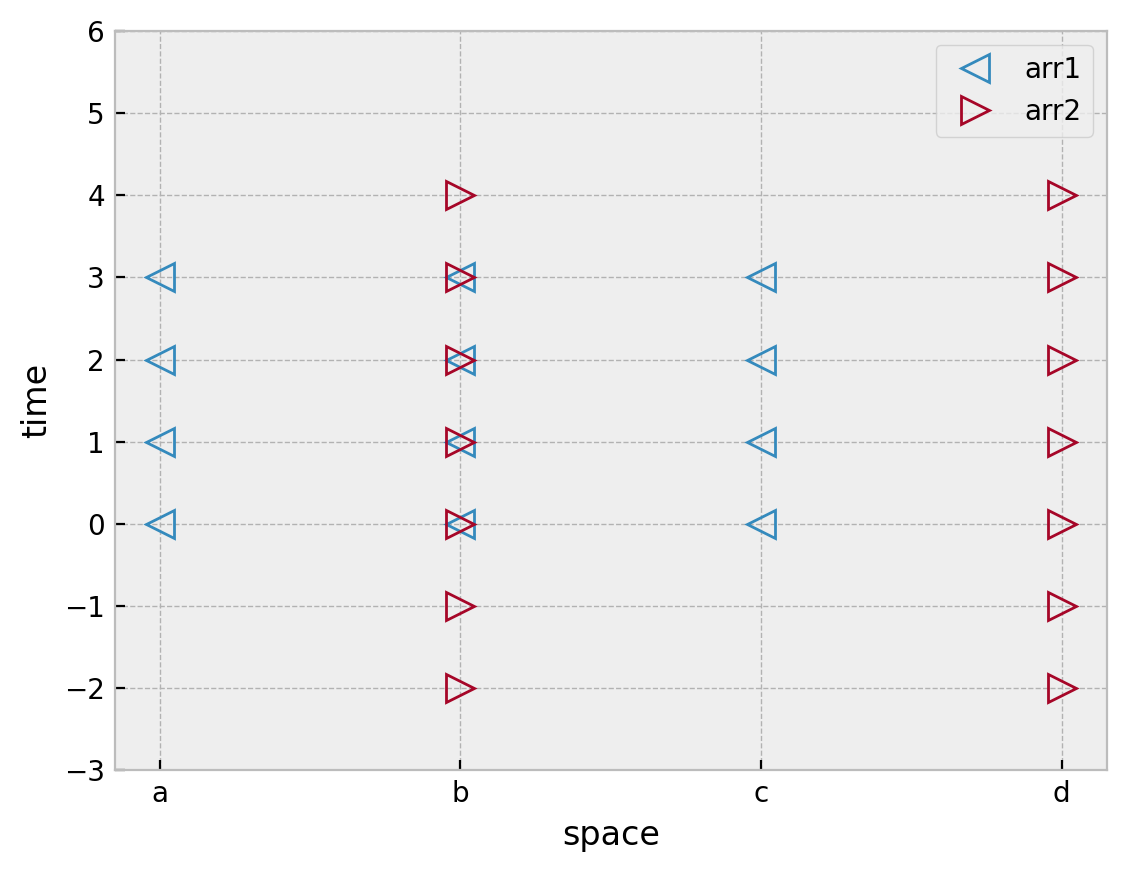

                                                                                                              
                                          Total time elapsed: 1.279 seconds                                   
                                       320 GPU function calls in 0.110 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__      │ 146        │ 0.048       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 146        │ 0.046       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 6          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 6          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__  │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__   │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 4          │ 0.004       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 4          │ 0.003       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [14]:
%%cudf.pandas.profile

def visualize_mesh(array, *args, ax=None, **kwargs):
    """Visualizes array's mesh ((points at which values are present)."""

    # Use broadcast to generate 2D x_, y_ arrays from the 1D x,y arrays
    space_, time_ = xr.broadcast(array.space, array.time)
    if ax is None:
        ax = plt.gca()
    kwargs.setdefault("fillstyle", "none")
    kwargs.setdefault("markersize", 10)
    ax.plot(space_.data.ravel(), time_.data.ravel(), *args, **kwargs)
    ax.set_xlabel("space")
    ax.set_ylabel("time")


visualize_mesh(arr1, "<")
visualize_mesh(arr2, ">")
plt.ylim([-3, 6])
plt.legend(["arr1", "arr2"]);

We see that both arrays only have values in common at `x="b"` and `y=[0, 1, 2, 3]`. Before applying an arithmetic operation we must first modify each DataArray so that they have values at the *same* points. This is "alignment".

### Controlling alignment

We can explicitly align objects using [xr.align](https://docs.xarray.dev/en/stable/generated/xarray.align.html). The key decision to make is how to decide which points must be kept. The other way to think of alignment is that objects must be converted to a common grid prior to any operation combining multiiple objects. This decision is controlled by the `"join"` keyword argument. Xarray provides 5 ways to convert the coordinate labels of multiple Datasets to a common grid. This [terminology](https://en.wikipedia.org/wiki/Join_(SQL)) originates in the database community.

1. `join="inner"` or reindex to the "intersection set" of coordinate labels
2. `join="outer"` or reindex to the "union set" of coordinate labels
3. `join="left"`  or reindex to the coordinate labels of the leftmost object
4. `join="right"` or reindex to the coordinate labels of the rightmost object
5. `join="exact"` checks for exact equality of coordinate labels before the operation.

First lets try an inner join. This is the default for arithmetic operations in Xarray. We see that the result has values for locations that `arr1` and `arr2` have in common: `x="b"` and `y=[0, 1, 2, 3]`. Here is an illustration

![](../images/alignment_schematic.png)

In [15]:
%%cudf.pandas.profile

a1_aligned, a2_aligned = xr.align(arr1, arr2, join="inner")
a1_aligned

<xarray.DataArray (space: 1, time: 4)>
array([[4, 5, 6, 7]])
Coordinates:
  * space    (space) <U1 'b'
  * time     (time) int64 0 1 2 3

                                                                                                              
                                          Total time elapsed: 0.322 seconds                                   
                                       168 GPU function calls in 0.085 seconds                                
                                        4 CPU function calls in 0.019 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__      │ 40         │ 0.013       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 91         │ 0.029       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals       │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.intersection │ 1          │ 0.010       │ 0.010       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.equals        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.intersection  │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 2          │ 0.003       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index.get_indexer        │ 0          │ 0.000       │ 0.000       │ 2          │ 0.010       │ 0.005       │
│ ndarray.reshape          │ 6          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.get_indexer   │ 0          │ 0.000       │ 0.000       │ 2          │ 0.009       │ 0.004       │
│ ndarray.__lt__           │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.any              │ 4          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype           │ 5          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__   │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__      │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Index.get_indexer
- Int64Index.get_indexer

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=821131;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [16]:
%%cudf.pandas.profile

a2_aligned

<xarray.DataArray (space: 1, time: 4)>
array([[2, 3, 4, 5]])
Coordinates:
  * space    (space) <U1 'b'
  * time     (time) int64 0 1 2 3

                                                                                                            
                                         Total time elapsed: 0.169 seconds                                  
                                       99 GPU function calls in 0.042 seconds                               
                                       0 CPU function calls in 0.000 seconds                                
                                                                                                            
                                                       Stats                                                
                                                                                                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function               ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__    │ 20         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__     │ 71         │ 0.024       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__ │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__    │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Here's a visual depiction of all the `join` options

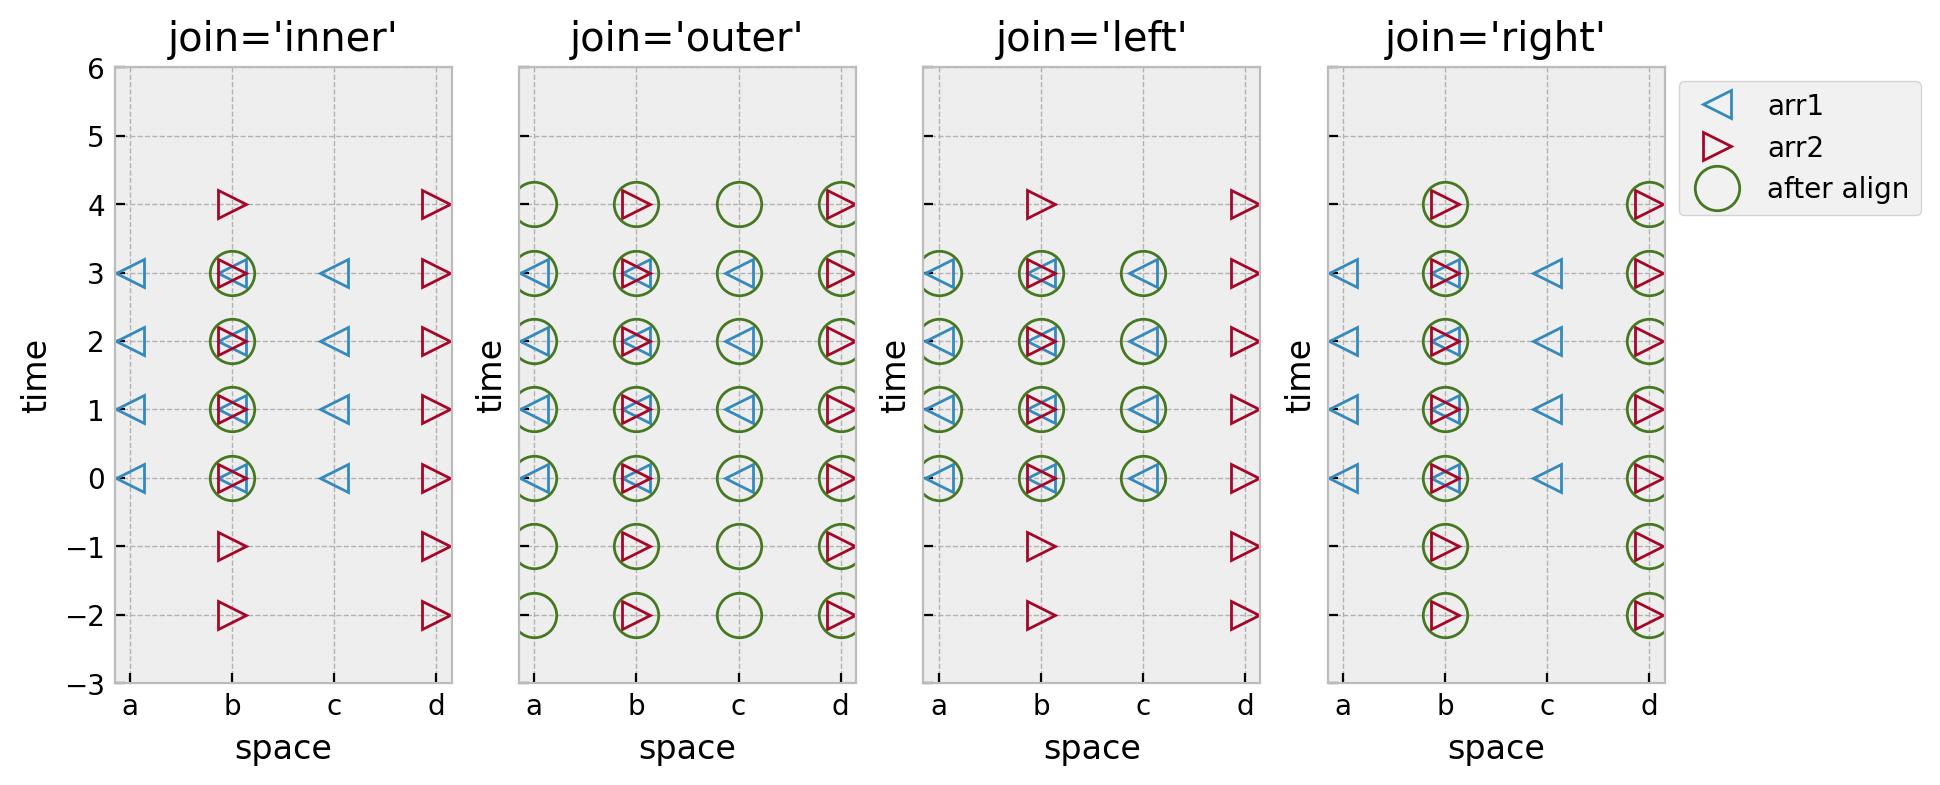

                                                                                                              
                                          Total time elapsed: 5.921 seconds                                   
                                       2191 GPU function calls in 0.814 seconds                               
                                        16 CPU function calls in 0.077 seconds                                
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__      │ 948        │ 0.302       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 948        │ 0.297       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals       │ 4          │ 0.003       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.intersection │ 1          │ 0.009       │ 0.009       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 38         │ 0.016       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.equals        │ 4          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.intersection  │ 1          │ 0.006       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 38         │ 0.016       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 32         │ 0.031       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 32         │ 0.027       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index.get_indexer        │ 0          │ 0.000       │ 0.000       │ 8          │ 0.041       │ 0.005       │
│ ndarray.reshape          │ 31         │ 0.011       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.get_indexer   │ 0          │ 0.000       │ 0.000       │ 8          │ 0.036       │ 0.005       │
│ ndarray.__lt__           │ 16         │ 0.008       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.any              │ 16         │ 0.009       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype           │ 25         │ 0.011       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__  │ 24         │ 0.011       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__   │ 24         │ 0.011       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.union        │ 1          │ 0.021       │ 0.021       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.union         │ 1          │ 0.016       │ 0.016       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__eq__           │ 7          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Index.get_indexer
- Int64Index.get_indexer

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=990270;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [17]:
%%cudf.pandas.profile

def visualize_join(a1, a2, join, ax=None):
    a1_aligned, a2_aligned = xr.align(arr1, arr2, join=join)

    visualize_mesh(a1, "<", ax=ax)
    visualize_mesh(a2, ">", ax=ax)
    visualize_mesh(a1_aligned, ".", markersize=32, color="C3", ax=ax)

    ax.set_ylim([-3, 6])
    ax.set_title(f"join={join!r}")


f, ax = plt.subplots(1, 4, sharex=True, sharey=True)
for axx, join in zip(ax, ["inner", "outer", "left", "right"]):
    visualize_join(arr1, arr2, join, ax=axx)
ax[-1].legend(["arr1", "arr2", "after align"], bbox_to_anchor=(1, 1))
f.set_size_inches(10, 4);

````{exercise}
:label: dims

Consider the following two arrays. Write down the `x` and `y` coordinate locations for `da1 - da2`
```python
da1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("space", "time"),
    coords={"space": ["a", "b", "c"], "time": [0, 1, 2, 3]},
)
da2 = xr.DataArray(
    [0, 1],
    dims="space",
    coords={"space": ["b", "d"]},
)
```
````

```{solution} dims
:class: dropdown

`x = ["b"], y=[0, 1, 2, 3]` . `da2` has been broadcasted to 2D  (so dimension "y" has been inserted) and the two arrays are aligned using `join="inner"` prior to subtraction.
```

### Further control over alignment

#### Controlling the fill value

For all join options other than `"inner"` Xarray will insert a `fill_value` at locations not present in the original dataset. By default this is NaN

In [18]:
%%cudf.pandas.profile

arr1_aligned, _ = xr.align(arr1, arr2, join="outer")
arr1_aligned

<xarray.DataArray (space: 4, time: 7)>
array([[nan, nan,  0.,  1.,  2.,  3., nan],
       [nan, nan,  4.,  5.,  6.,  7., nan],
       [nan, nan,  8.,  9., 10., 11., nan],
       [nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c' 'd'
  * time     (time) int64 -2 -1 0 1 2 3 4

                                                                                                              
                                          Total time elapsed: 0.399 seconds                                   
                                       234 GPU function calls in 0.124 seconds                                
                                        4 CPU function calls in 0.018 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__      │ 91         │ 0.027       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 91         │ 0.027       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals       │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.union        │ 1          │ 0.020       │ 0.020       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.equals        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.union         │ 1          │ 0.014       │ 0.014       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index.get_indexer        │ 0          │ 0.000       │ 0.000       │ 2          │ 0.010       │ 0.005       │
│ ndarray.reshape          │ 9          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.get_indexer   │ 0          │ 0.000       │ 0.000       │ 2          │ 0.008       │ 0.004       │
│ ndarray.__lt__           │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.any              │ 4          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype           │ 8          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__eq__           │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__  │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__   │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__      │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Index.get_indexer
- Int64Index.get_indexer

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=483432;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

Control the "fill value" by specifying the `fill_value` keyword argument

In [19]:
%%cudf.pandas.profile

arr1_aligned, _ = xr.align(arr1, arr2, join="outer", fill_value=0)
arr1_aligned

<xarray.DataArray (space: 4, time: 7)>
array([[ 0,  0,  0,  1,  2,  3,  0],
       [ 0,  0,  4,  5,  6,  7,  0],
       [ 0,  0,  8,  9, 10, 11,  0],
       [ 0,  0,  0,  0,  0,  0,  0]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c' 'd'
  * time     (time) int64 -2 -1 0 1 2 3 4

                                                                                                              
                                          Total time elapsed: 0.397 seconds                                   
                                       234 GPU function calls in 0.125 seconds                                
                                        4 CPU function calls in 0.018 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__      │ 91         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 91         │ 0.027       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals       │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.union        │ 1          │ 0.018       │ 0.018       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.equals        │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.union         │ 1          │ 0.015       │ 0.015       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__  │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index.get_indexer        │ 0          │ 0.000       │ 0.000       │ 2          │ 0.009       │ 0.005       │
│ ndarray.reshape          │ 9          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.get_indexer   │ 0          │ 0.000       │ 0.000       │ 2          │ 0.008       │ 0.004       │
│ ndarray.__lt__           │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.any              │ 4          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype           │ 8          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__eq__           │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__  │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__   │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__     │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__      │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Index.get_indexer
- Int64Index.get_indexer

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=623866;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

#### Checking that objects are aligned

`join="exact"` is special in that it checks to make sure that the objects _are_ aligned.

For `arr1` and `arr2` this will raise an error since `arr1.x` is not identical to `arr2.x` (and similarly for `y`)

In [20]:
%%cudf.pandas.profile

xr.align(arr1, arr2, join="exact")

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'space' ('space',)

                                                                                                         
                                        Total time elapsed: 1.311 seconds                                
                                     13 GPU function calls in 0.005 seconds                              
                                      0 CPU function calls in 0.000 seconds                              
                                                                                                         
                                                      Stats                                              
                                                                                                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function            ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__ │ 6          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__  │ 6          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals  │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
└─────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

#### Controlling automatic alignment

Xarray's default for arithmetic operations is `join="inner"`. This is controllable using the [xr.set_options](https://docs.xarray.dev/en/stable/generated/xarray.set_options.html) context manager

In [21]:
%%cudf.pandas.profile

with xr.set_options(arithmetic_join="outer"):
    result = arr1 - arr2
result

<xarray.DataArray (space: 4, time: 7)>
array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan,  2.,  2.,  2.,  2., nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c' 'd'
  * time     (time) int64 -2 -1 0 1 2 3 4

                                                                                                             
                                          Total time elapsed: 0.420 seconds                                  
                                       232 GPU function calls in 0.128 seconds                               
                                        4 CPU function calls in 0.020 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ StringIndex.__len__     │ 91         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 91         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals      │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.union       │ 1          │ 0.022       │ 0.022       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.equals       │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.union        │ 1          │ 0.016       │ 0.016       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index.get_indexer       │ 0          │ 0.000       │ 0.000       │ 2          │ 0.010       │ 0.005       │
│ ndarray.reshape         │ 9          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.get_indexer  │ 0          │ 0.000       │ 0.000       │ 2          │ 0.010       │ 0.005       │
│ ndarray.__lt__          │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.any             │ 4          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype          │ 8          │ 0.004       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__eq__          │ 3          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__ │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__repr__    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Index.get_indexer
- Int64Index.get_indexer

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=324925;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.